In [1]:
import pandas as pd
import numpy as np
import random as rd
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

import warnings 
warnings.filterwarnings('ignore') 

In /Users/han/opt/anaconda3/envs/Heating-System-Analysis/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/han/opt/anaconda3/envs/Heating-System-Analysis/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/han/opt/anaconda3/envs/Heating-System-Analysis/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/han/opt/anaconda3/envs/Heating-System-Analysis/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated 

In [2]:
#SOM算法实现

import numpy as np

class SOM():
    """
    The 2-D, rectangular grid self-organizing map class using Numpy.
    """
    def __init__(self, m=3, n=3, dim=3, lr=1, sigma=1, max_iter=3000):
        """
        Parameters
        ----------
        m : int, default=3
            The shape along dimension 0 (vertical) of the SOM.
        n : int, default=3
            The shape along dimesnion 1 (horizontal) of the SOM.
        dim : int, default=3
            The dimensionality (number of features) of the input space.
        lr : float, default=1
            The initial step size for updating the SOM weights.
        sigma : float, optional
            Optional parameter for magnitude of change to each weight. Does not
            update over training (as does learning rate). Higher values mean
            more aggressive updates to weights.
        max_iter : int, optional
            Optional parameter to stop training if you reach this many
            interation.
        """
        # Initialize descriptive features of SOM
        self.m = m
        self.n = n
        self.dim = dim
        self.shape = (m, n)
        self.initial_lr = lr
        self.lr = lr
        self.sigma = sigma
        self.max_iter = max_iter

        # Initialize weights
        self.weights = np.random.normal(size=(m * n, dim))
        self._locations = self._get_locations(m, n)

        # Set after fitting
        self._inertia = None
        self._n_iter_ = None
        self._trained = False

    def _get_locations(self, m, n):
        """
        Return the indices of an m by n array.
        """
        return np.argwhere(np.ones(shape=(m, n))).astype(np.int64)

    def _find_bmu(self, x):
        """
        Find the index of the best matching unit for the input vector x.
        """
        # Stack x to have one row per weight
        x_stack = np.stack([x]*(self.m*self.n), axis=0)
        # Calculate distance between x and each weight
        distance = np.linalg.norm(x_stack - self.weights, axis=1)
        # Find index of best matching unit
        return np.argmin(distance)

    def step(self, x):
        """
        Do one step of training on the given input vector.
        """
        # Stack x to have one row per weight
        x_stack = np.stack([x]*(self.m*self.n), axis=0)

        # Get index of best matching unit
        bmu_index = self._find_bmu(x)

        # Find location of best matching unit
        bmu_location = self._locations[bmu_index,:]

        # Find square distance from each weight to the BMU
        stacked_bmu = np.stack([bmu_location]*(self.m*self.n), axis=0)
        bmu_distance = np.sum(np.power(self._locations.astype(np.float64) - stacked_bmu.astype(np.float64), 2), axis=1)

        # Compute update neighborhood
        neighborhood = np.exp((bmu_distance / (self.sigma ** 2)) * -1)
        local_step = self.lr * neighborhood

        # Stack local step to be proper shape for update
        local_multiplier = np.stack([local_step]*(self.dim), axis=1)

        # Multiply by difference between input and weights
        delta = local_multiplier * (x_stack - self.weights)

        # Update weights
        self.weights += delta

    def _compute_point_intertia(self, x):
        """
        Compute the inertia of a single point. Inertia defined as squared distance
        from point to closest cluster center (BMU)
        """
        # Find BMU
        bmu_index = self._find_bmu(x)
        bmu = self.weights[bmu_index]
        # Compute sum of squared distance (just euclidean distance) from x to bmu
        return np.sum(np.square(x - bmu))

    def fit(self, X, epochs=1, shuffle=True):
        """
        Take data (a tensor of type float64) as input and fit the SOM to that
        data for the specified number of epochs.
        Parameters
        ----------
        X : ndarray
            Training data. Must have shape (n, self.dim) where n is the number
            of training samples.
        epochs : int, default=1
            The number of times to loop through the training data when fitting.
        shuffle : bool, default True
            Whether or not to randomize the order of train data when fitting.
            Can be seeded with np.random.seed() prior to calling fit.
        Returns
        -------
        None
            Fits the SOM to the given data but does not return anything.
        """
        # Count total number of iterations
        global_iter_counter = 0
        n_samples = X.shape[0]
        total_iterations = np.minimum(epochs * n_samples, self.max_iter)

        for epoch in range(epochs):
            # Break if past max number of iterations
            if global_iter_counter > self.max_iter:
                break

            if shuffle:
                indices = np.random.permutation(n_samples)
            else:
                indices = np.arange(n_samples)

            # Train
            for idx in indices:
                # Break if past max number of iterations
                if global_iter_counter > self.max_iter:
                    break
                input = X[idx]
                # Do one step of training
                self.step(input)
                # Update learning rate
                global_iter_counter += 1
                self.lr = (1 - (global_iter_counter / total_iterations)) * self.initial_lr

        # Compute inertia
        inertia = np.sum(np.array([float(self._compute_point_intertia(x)) for x in X]))
        self._inertia_ = inertia

        # Set n_iter_ attribute
        self._n_iter_ = global_iter_counter

        # Set trained flag
        self._trained = True

        return

    def predict(self, X):
        """
        Predict cluster for each element in X.
        Parameters
        ----------
        X : ndarray
            An ndarray of shape (n, self.dim) where n is the number of samples.
            The data to predict clusters for.
        Returns
        -------
        labels : ndarray
            An ndarray of shape (n,). The predicted cluster index for each item
            in X.
        """
        # Check to make sure SOM has been fit
        if not self._trained:
            raise NotImplementedError('SOM object has no predict() method until after calling fit().')

        # Make sure X has proper shape
        assert len(X.shape) == 2, f'X should have two dimensions, not {len(X.shape)}'
        assert X.shape[1] == self.dim, f'This SOM has dimesnion {self.dim}. Received input with dimension {X.shape[1]}'

        labels = np.array([self._find_bmu(x) for x in X])
        return labels

    def transform(self, X):
        """
        Transform the data X into cluster distance space.
        Parameters
        ----------
        X : ndarray
            Data of shape (n, self.dim) where n is the number of samples. The
            data to transform.
        Returns
        -------
        transformed : ndarray
            Transformed data of shape (n, self.n*self.m). The Euclidean distance
            from each item in X to each cluster center.
        """
        # Stack data and cluster centers
        X_stack = np.stack([X]*(self.m*self.n), axis=1)
        cluster_stack = np.stack([self.weights]*X.shape[0], axis=0)

        # Compute difference
        diff = X_stack - cluster_stack

        # Take and return norm
        return np.linalg.norm(diff, axis=2)

    def fit_predict(self, X, **kwargs):
        """
        Convenience method for calling fit(X) followed by predict(X).
        Parameters
        ----------
        X : ndarray
            Data of shape (n, self.dim). The data to fit and then predict.
        **kwargs
            Optional keyword arguments for the .fit() method.
        Returns
        -------
        labels : ndarray
            ndarray of shape (n,). The index of the predicted cluster for each
            item in X (after fitting the SOM to the data in X).
        """
        # Fit to data
        self.fit(X, **kwargs)

        # Return predictions
        return self.predict(X)

    def fit_transform(self, X, **kwargs):
        """
        Convenience method for calling fit(X) followed by transform(X). Unlike
        in sklearn, this is not implemented more efficiently (the efficiency is
        the same as calling fit(X) directly followed by transform(X)).
        Parameters
        ----------
        X : ndarray
            Data of shape (n, self.dim) where n is the number of samples.
        **kwargs
            Optional keyword arguments for the .fit() method.
        Returns
        -------
        transformed : ndarray
            ndarray of shape (n, self.m*self.n). The Euclidean distance
            from each item in X to each cluster center.
        """
        # Fit to data
        self.fit(X, **kwargs)

        # Return points in cluster distance space
        return self.transform(X)

    @property
    def cluster_centers_(self):
        return self.weights.reshape(self.m, self.n, self.dim)

    @property
    def inertia_(self):
        if self._inertia_ is None:
            raise AttributeError('SOM does not have inertia until after calling fit()')
        return self._inertia_

    @property
    def n_iter_(self):
        if self._n_iter_ is None:
            raise AttributeError('SOM does not have n_iter_ attribute until after calling fit()')
        return self._n_iter_

In [3]:
#PSO优化的随机森林算法进行特征选择

import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


def set_parameters(
    model,
    X,
    y,
    fit: str = "fit",
    predict: str = "predict",
    threshold: float = 0.5,
    test_size: float = 0.2,
    **kwrgs
):
    def fitness(x):
        mdl = model(**kwrgs)
        return fitness_function(
            x, mdl, X, y, threshold, test_size, fit=fit, predict=predict
        )

    return fitness


def fitness_function(
    x,
    model,
    X,
    y,
    threshold: float = 0.5,
    test_size: float = 0.2,
    fit: str = "fit",
    predict: str = "predict",
):

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, shuffle=True, test_size=test_size
    )

    par_ = [1 if col > threshold else 0 for col in x]
    cols = np.argwhere(par_ == np.amax(par_)).reshape(
        -1,
    )
    x_train = X_train[:, cols]
    x_test = X_test[:, cols]

    getattr(model, fit)(x_train, y_train)

    y_p = getattr(model, predict)(x_test)
    acc = accuracy_score(y_test, y_p)

    return 1 - acc



def PSO(
    fitness_function,
    particle_size: int,
    particle_dim: int,
    bounds: list,
    intertial_weight: int,
    particle_coeff: int,
    swarm_coeff: int,
    epochs: int,
    threshold_epochs: int = None,
    verbose: float = False,
):

    pop = np.array([bounds[0]] * particle_dim) + np.array(
        [abs(bounds[1] - bounds[0])] * particle_dim
    ) * np.random.rand(
        particle_size, particle_dim
    )  # initial population

    vel = np.array([bounds[0]] * particle_dim) + np.array(
        [abs(bounds[1] - bounds[0]) / 2] * particle_dim
    ) * np.random.rand(particle_size, particle_dim)

    fit = np.array([fitness_function(p) for p in pop])

    if verbose:
        all_featues = np.ones(particle_dim)
        print(f"Initial Accuracy: %.3f." % (1 - fitness_function(all_featues)))

    pbest = np.copy(pop)
    f_pbest = np.copy(fit)

    f_gbest, gbest = np.min(f_pbest), pbest[np.argmin(f_pbest)]
    best_fit_epochs = []
    best_particle_epochs = []

    # iterating over the entire population

    for epoch in range(epochs):
        if verbose:
            print("----------------------------------")
            print(
                "*  Epoch: {epoch:{width}}".format(
                    epoch=epoch + 1, width=len(str(epochs))
                ),
                end=" | ",
            )

        # updating individuals in the population

        for p in range(particle_size):

            vel[p, :] = (
                (intertial_weight * vel[p, :])
                + (
                    particle_coeff
                    * np.random.rand(1, particle_dim)
                    * (pbest[p, :] - pop[p, :])
                )
                + (swarm_coeff * np.random.rand(1, particle_dim) * (gbest - pop[p, :]))
            )

            pop[p, :] += vel[p, :]
            pop[p, :] = np.where(pop[p] > 1, 1.0, np.where(pop[p] < 0, 0.0, pop[p]))

            fit[p] = fitness_function(pop[p, :])

            if fit[p] < f_pbest[p]:
                f_pbest[p] = fit[p]
                pbest[p] = pop[p]

                if f_pbest[p] < f_gbest:
                    f_gbest = f_pbest[p]
                    gbest = pbest[p]

        if verbose:
            print("Accuracy: %.3f." % (1 - f_gbest))

        best_fit_epochs.append(f_gbest)
        best_particle_epochs.append(gbest)
        if (
            threshold_epochs
            and len(best_fit_epochs) >= threshold_epochs
            and np.all(best_fit_epochs[-1] == best_fit_epochs[-threshold_epochs:])
        ):
            break

    if verbose:
        print("----------------------------------")

    return (best_fit_epochs, best_particle_epochs)


def PSOptimizer(
    dataset: tuple,
    model,
    fit: str = "fit",
    predict: str = "predict",
    epochs: int = 10,
    threshold: float = 0.5,
    test_size: float = 0.2,
    early_stopping: bool = False,
    verbose: bool = False,
    **kwargs
):
    """
    Particle Swarm Optimizer
    ------------------------
    Parameters
    ----------
    - dataset : tuple, default=None
        The dataset to find optimized features for.
    - model : function, default=None
        The model which is to be trained to make predictions on the dataset.
    - fit : str, default='fit'
        THe method used by the model to fit to training data.
    - predict : str, default='predict'
        THe method used by the model to predict given the input.
    Output
    ------
    - accuracy : Best accuracy score found by the optimizer.
    - features : features which get the best accuracy attanined.
    """

    opt = "PSO"

    X, y = dataset

    # setting hyperparameters

    DIM = X.shape[1]
    BOUNDS = [0.0, 1.0]

    EPOCHS = epochs  # the number of iterations for which the swarm will train
    w = 0.50  # inertial value for effect of current velocity
    c1 = 0.45  # coeff for effect of particle best position
    c2 = 0.55  # coeff for effect of swarm best position
    SIZE = 50  # number of particles

    fitness = set_parameters(model, X, y, fit, predict, threshold, test_size, **kwargs)

    losses, features = PSO(
        fitness,
        SIZE,
        DIM,
        BOUNDS,
        w,
        c1,
        c2,
        EPOCHS,
        int(EPOCHS / 5) if early_stopping else None,
        verbose,
    )
    loss, feature = losses[-1], features[-1]
    accuracy = 1 - loss

    feature = [1 if attr > threshold else 0 for attr in feature]
    feature = np.argwhere(feature == np.max(feature)).reshape(
        -1,
    )

    return (accuracy, feature)


# 一、读入数据

In [4]:
data = pd.read_csv('2016.csv')
data.describe()

,"М1, t","М2, t","ΔМ, t","Т1, °C","Т2, °C","ΔТ, °C","Q, Gcal",USPD,YYYYMM,type,area,floors,year of construction,area of building,"temp,˚C"
count,164792.000000,164792.000000,164792.000000,164792.000000,164792.000000,164792.000000,164792.000000,164792.000000,164792.000000,164792.000000,164792.000000,164792.000000,164792.000000,164792.000000,164792.000000
mean,137.630041,133.575492,4.054543,76.274687,50.367019,25.907669,3.385007,1124.833505,201605.566302,1664.243950,3476.709410,6.515419,1978.648545,7066.471478,-7.304365
std,111.781591,111.300147,7.543280,11.042464,5.812095,8.006409,2.535829,807.946417,4.239587,473.738562,2268.625664,2.305540,12.598548,6322.387367,10.247033
min,0.800000,0.010000,-25.600000,40.010000,6.380000,2.050000,0.010000,1.000000,201601.000000,1102.000000,169.400000,1.000000,1882.000000,169.400000,-32.582617
25%,75.080000,71.470000,-0.190000,66.880000,46.310000,20.310000,1.880000,457.000000,201602.000000,1105.000000,2143.700000,5.000000,1970.000000,3418.500000,-14.349412
50%,113.040000,107.590000,2.000000,74.900000,49.760000,25.470000,2.760000,999.000000,201604.000000,2005.000000,2943.700000,5.000000,1979.000000,4767.000000,-7.930418
75%,157.250000,152.680000,7.000000,85.220000,54.260000,31.590000,4.040000,1670.000000,201611.000000,2105.000000,3964.800000,9.000000,1987.000000,7943.900000,0.582159
max,1675.390000,1659.390000,514.310000,116.990000,87.510000,62.710000,28.670000,3162.000000,201612.000000,2117.000000,18801.100000,17.000000,2015.000000,32030.920000,16.963864


In [5]:
data = data.rename(columns={'temp,˚C': 'temp','Q, Gcal':'Q', 'М1, t':'M1', 'М2, t':'M2', 'Т1, °C':'T1', 'Т2, °C':'T2', 'ΔМ, t':'delta_M', 'ΔТ, °C':'delta_T'})
#data['Date'] = pd.to_datetime(data['Date'])
data.describe()

,M1,M2,delta_M,T1,T2,delta_T,Q,USPD,YYYYMM,type,area,floors,year of construction,area of building,temp
count,164792.000000,164792.000000,164792.000000,164792.000000,164792.000000,164792.000000,164792.000000,164792.000000,164792.000000,164792.000000,164792.000000,164792.000000,164792.000000,164792.000000,164792.000000
mean,137.630041,133.575492,4.054543,76.274687,50.367019,25.907669,3.385007,1124.833505,201605.566302,1664.243950,3476.709410,6.515419,1978.648545,7066.471478,-7.304365
std,111.781591,111.300147,7.543280,11.042464,5.812095,8.006409,2.535829,807.946417,4.239587,473.738562,2268.625664,2.305540,12.598548,6322.387367,10.247033
min,0.800000,0.010000,-25.600000,40.010000,6.380000,2.050000,0.010000,1.000000,201601.000000,1102.000000,169.400000,1.000000,1882.000000,169.400000,-32.582617
25%,75.080000,71.470000,-0.190000,66.880000,46.310000,20.310000,1.880000,457.000000,201602.000000,1105.000000,2143.700000,5.000000,1970.000000,3418.500000,-14.349412
50%,113.040000,107.590000,2.000000,74.900000,49.760000,25.470000,2.760000,999.000000,201604.000000,2005.000000,2943.700000,5.000000,1979.000000,4767.000000,-7.930418
75%,157.250000,152.680000,7.000000,85.220000,54.260000,31.590000,4.040000,1670.000000,201611.000000,2105.000000,3964.800000,9.000000,1987.000000,7943.900000,0.582159
max,1675.390000,1659.390000,514.310000,116.990000,87.510000,62.710000,28.670000,3162.000000,201612.000000,2117.000000,18801.100000,17.000000,2015.000000,32030.920000,16.963864


In [6]:
import datetime
from datetime import datetime

data_temp_date = data.groupby("Date").temp.mean()
data_Q_date = data.groupby("Date").Q.mean()
merged_temp_Q = pd.merge(data_temp_date, data_Q_date, on='Date')
merged_temp_Q['Date'] = merged_temp_Q.index
merged_temp_Q['Date'] = pd.to_datetime(merged_temp_Q['Date'])

merged_temp_Q = merged_temp_Q.reset_index(drop=True)
merged_temp_Q = merged_temp_Q.sort_values(['Date'])

merged_temp_Q['Date']= merged_temp_Q['Date'].apply(lambda x: datetime.strftime(x,'%Y-%m-%d'))
merged_temp_Q.describe()


,temp,Q
count,220.000000,220.000000
mean,-6.771093,3.302338
std,10.036346,0.864934
min,-32.582617,0.793787
25%,-13.290211,2.569404
50%,-6.160375,3.225212
75%,0.584797,3.951401
max,16.963864,5.137470


<Figure size 432x288 with 0 Axes>

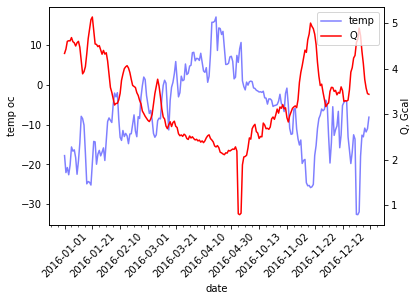

In [7]:
# 将返回既是fig图形对象又axes是2x1的轴对象数组,也就是两行一列的两个子图
# 和以下三句等同
from matplotlib.ticker import MultipleLocator, FormatStrFormatter 


fig=plt.figure()

Date_2016 = merged_temp_Q['Date']
Temp_2016 = merged_temp_Q['temp']
Q_2016 = merged_temp_Q['Q']
# axs[0]表示第一个图
#plt.plot(merged_temp_Q['Date'], merged_temp_Q['Q'], merged_temp_Q['Date'], merged_temp_Q['temp'])
# grid(true)绘制刻度线的网格 False不绘制
#plt.grid(False)
# axs[1]表示第二个图 dt为步长
# 绘制s1和s2相关性函数，NNFT=256应该是默认参数
#cxy, f = axs[1].cohere(merged_temp_Q['Q'], merged_temp_Q['temp'], 256, 1. / dt)
fig, ax1 = plt.subplots()
plt.xticks(rotation=45)
ax1.plot(Date_2016, Temp_2016, color="blue", alpha=0.5, label="temp")
ax1.set_xlabel("date")
ax1.set_ylabel("temp oc")


ax2 = ax1.twinx()
ax2.plot(Date_2016, Q_2016, color="red", label="Q")
ax2.set_ylabel("Q, Gcal")

fig.legend(loc="upper right", bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)


xmajorLocator  = MultipleLocator(20) #将x主刻度标签设置为20的倍数 
xminorLocator  = MultipleLocator(5) #将x轴次刻度标签设置为5的倍数 
ymajorLocator  = MultipleLocator(0.5) #将y轴主刻度标签设置为0.5的倍数 
yminorLocator  = MultipleLocator(0.1) #将此y轴次刻度标签设置为0.1的倍数 

#设置主刻度标签的位置,标签文本的格式 
ax1.xaxis.set_major_locator(xmajorLocator) 
#显示次刻度标签的位置,没有标签文本 
ax1.xaxis.set_minor_locator(xminorLocator) 
#tight_layout会自动调整子图参数，使之填充适应整个图像区域


plt.show( )

## 1. 查看目标值分布

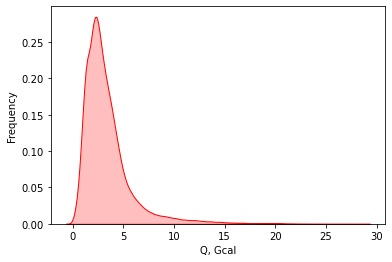

In [8]:
Q_Gcal = data[['Q']]

h = sns.kdeplot(Q_Gcal.Q, color="Red", shade = True)
h.set_xlabel("Q, Gcal")
h.set_ylabel("Frequency")
plt.show()

当数据呈现长尾分布时，会导致分类器出现bias(势利眼)，分类器更偏向于识别样本量充足，类内多样性丰富的头部类，从而忽略了尾部类，这对尾部类而言是不公平的。由于尾部ID的数量庞大，而且每个尾部ID所拥有的样本数量稀少，这会导致特征空间十分混乱，大量类别的辨识度不高，使得特征空间发生扭曲，畸变。最终网络学习得到的是一个不健康的模型，先天畸形

In [9]:
np_Qcal = data['Q'].to_list()

Optimal lambda value: 0.04767224508617792


<AxesSubplot:>

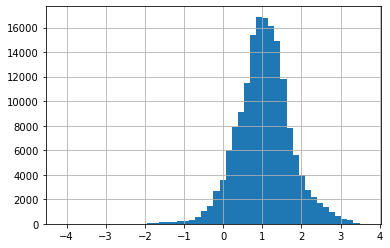

In [10]:
import scipy.stats as spstats
#Box-Cox变换是Box和Cox在1964年提出的一种广义幂变换方法，
# 是统计建模中常用的一种数据变换，用于连续的响应变量不满足正态分布的情况。
# Box-Cox变换之后，可以一定程度上减小不可观测的误差和预测变量的相关性。
# Box-Cox变换的主要特点是引入一个参数，通过数据本身估计该参数进而确定应采取的数据变换形式，
# Box-Cox变换可以明显地改善数据的正态性、对称性和方差相等性，对许多实际数据都是行之有效的。

# 从数据分布中移除非零值
np_Q = np.array(data['Q'])
# income_clean = income[~np.isnan(income)]
# 计算最佳λ值
l, opt_lambda = spstats.boxcox(np_Q)
print('Optimal lambda value:', opt_lambda)
 
# 进行Box-Cox变换
data['Q_boxcox_lambda_opt'] = spstats.boxcox(data['Q'],lmbda=opt_lambda)
data['Q_boxcox_lambda_opt'].hist(bins=50)

In [11]:


u = data['Q_boxcox_lambda_opt'].mean()
std = data['Q_boxcox_lambda_opt'].std()
kstest = spstats.kstest(data['Q_boxcox_lambda_opt'], 'norm', args=(u, std))
kstest

KstestResult(statistic=0.03205695605235781, pvalue=1.459895094979723e-147)

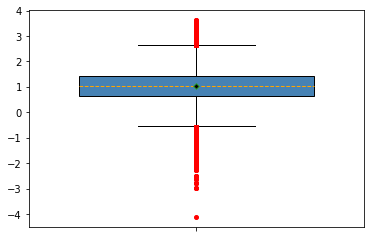

In [12]:
# 导入数据
sunspots = data['Q_boxcox_lambda_opt']
# 绘制箱线图（1.5倍的四分位差，如需绘制3倍的四分位差，只需调整whis参数）
plt.boxplot(x = sunspots, # 指定绘制箱线图的数据         
whis = 1.5, # 指定1.5倍的四分位差         
widths = 0.7, # 指定箱线图的宽度为0.8         
patch_artist = True, # 指定需要填充箱体颜色         
showmeans = True, # 指定需要显示均值         
boxprops = {'facecolor':'steelblue'}, # 指定箱体的填充色为铁蓝色        
# 指定异常点的填充色、边框色和大小         
flierprops = {'markerfacecolor':'red', 'markeredgecolor':'red', 'markersize':4},          
# 指定均值点的标记符号（菱形）、填充色和大小        
meanprops = {'marker':'D','markerfacecolor':'black', 'markersize':4},          
medianprops = {'linestyle':'--','color':'orange'}, # 指定中位数的标记符号（虚线）和颜色         
labels = [''] # 去除箱线图的x轴刻度值         
)# 显示图形
plt.show()



In [13]:
# 计算下四分位数和上四分位
Q1 = sunspots.quantile(q = 0.25)
Q3 = sunspots.quantile(q = 0.75)# 基于1.5倍的四分位差计算上下须对应的值
low_whisker = Q1 - 1.5*(Q3 - Q1)
up_whisker = Q3 + 1.5*(Q3 - Q1)# 寻找异常点
sunspots[(sunspots > low_whisker) & (sunspots < up_whisker)].describe()

count    160015.000000
mean          1.035817
std           0.598966
min          -0.554654
25%           0.646334
50%           1.036390
75%           1.427775
max           2.647421
Name: Q_boxcox_lambda_opt, dtype: float64

In [14]:
data = data[(data['Q_boxcox_lambda_opt'] > low_whisker) & (data['Q_boxcox_lambda_opt'] < up_whisker)]
data.describe()

,M1,M2,delta_M,T1,T2,delta_T,Q,USPD,YYYYMM,type,area,floors,year of construction,area of building,temp,Q_boxcox_lambda_opt
count,160015.000000,160015.000000,160015.000000,160015.000000,160015.000000,160015.000000,160015.000000,160015.000000,160015.000000,160015.000000,160015.000000,160015.000000,160015.000000,160015.000000,160015.000000,160015.000000
mean,131.630626,127.588355,4.042265,76.223770,50.295244,25.928526,3.204723,1117.197338,201605.580721,1659.883167,3347.222341,6.496922,1978.646852,6950.944623,-7.248583,1.035817
std,95.394703,95.056951,7.407126,10.930227,5.728461,7.932706,1.934681,803.774848,4.238828,474.166313,1926.205572,2.280989,12.082194,6232.251016,10.206878,0.598966
min,14.390000,0.010000,-25.600000,40.010000,6.380000,2.600000,0.570000,1.000000,201601.000000,1102.000000,330.700000,2.000000,1882.000000,361.800000,-32.582617,-0.554654
25%,75.590000,71.960000,-0.180000,66.910000,46.300000,20.350000,1.890000,456.000000,201602.000000,1105.000000,2145.100000,5.000000,1970.000000,3419.600000,-14.218860,0.646334
50%,112.580000,107.120000,2.050000,74.820000,49.680000,25.450000,2.750000,992.000000,201604.000000,2005.000000,2936.300000,5.000000,1979.000000,4744.300000,-7.625315,1.036390
75%,154.100000,149.675000,6.990000,85.010000,54.110000,31.540000,3.980000,1650.000000,201611.000000,2105.000000,3944.200000,9.000000,1987.000000,7684.550000,0.582159,1.427775
max,1675.390000,1659.390000,514.310000,112.600000,87.510000,60.440000,12.100000,3162.000000,201612.000000,2117.000000,18801.100000,17.000000,2015.000000,32030.920000,16.963864,2.647421


In [15]:
from scipy.stats import normaltest
k2, p = normaltest(data['Q_boxcox_lambda_opt'])
p

5.765531751573435e-37

## 二、 进行数据分箱:连续值变为离散值，回归任务变为分类任务

In [16]:
'''
import autoBinning
from autoBinning.utils.forwardSplit import *
# sby='woeiv'时考虑woe趋势，sby='iv'时不考虑woe趋势
t = forwardSplit(data['M1'], data['Q'])
t.fit(sby='iv',minv=0.1,init_split=6)
print(t.bins) 
t = forwardSplit(data['M1'], data['Q'])
t.fit(sby='iv',num_split=6,init_split=6)
print(t.bins) 

t.fit(sby='woeiv',num_split=6,init_split=6)
print(t.bins)

print("bin\t\twoe")
for i in range(len(t.bins)-1):
    v = t.value[(t.x < t.bins[i+1]) & (t.x >= t.bins[i])]
    woe = t._cal_woe(v)
    print((t.bins[i], t.bins[i+1]),woe)
    '''

'\nimport autoBinning\nfrom autoBinning.utils.forwardSplit import *\n# sby=\'woeiv\'时考虑woe趋势，sby=\'iv\'时不考虑woe趋势\nt = forwardSplit(data[\'M1\'], data[\'Q\'])\nt.fit(sby=\'iv\',minv=0.1,init_split=6)\nprint(t.bins) \nt = forwardSplit(data[\'M1\'], data[\'Q\'])\nt.fit(sby=\'iv\',num_split=6,init_split=6)\nprint(t.bins) \n\nt.fit(sby=\'woeiv\',num_split=6,init_split=6)\nprint(t.bins)\n\nprint("bin\t\twoe")\nfor i in range(len(t.bins)-1):\n    v = t.value[(t.x < t.bins[i+1]) & (t.x >= t.bins[i])]\n    woe = t._cal_woe(v)\n    print((t.bins[i], t.bins[i+1]),woe)\n    '

In [17]:
bins=[0,3,6,9,12,15]
bin_data = pd.cut(data['Q'], bins)
print(pd.value_counts(bin_data))

(0, 3]      90104
(3, 6]      56672
(6, 9]       9615
(9, 12]      3525
(12, 15]       99
Name: Q, dtype: int64


In [18]:
def func(x):
    if ((x<3) & (x>0)):
        return "1"
    elif ((x>=3) & (x<6)):
        return "2"
    elif ((x>=6) & (x<9)):
        return "3"
    elif ((x>=9) & (x<12)):  
        return "4"
    elif ((x>=12) & (x<15)):  
        return "5"
    elif ((x>=25) & (x<30)):
        return "6"
    elif (x>=30):
        return "7"
    else:
        return 'N/A'
data['level'] = data['Q'].apply(func)
data.head(10)

,Date,M1,M2,delta_M,T1,T2,delta_T,Q,USPD,YYYYMM,...,scheme,type,area,floors,walls material,year of construction,area of building,temp,Q_boxcox_lambda_opt,level
0,2016/1/1,102.51,92.05,10.46,81.99,53.36,28.63,2.94,1,201601,...,opened,1105,2707.40,5,panel,1983,4401.00,-17.782121,1.106611,1
1,2016/1/1,124.86,125.29,-0.43,82.58,50.24,32.34,4.05,3,201601,...,closed,2105,3358.40,5,brick,1974,3610.40,-17.782121,1.446404,2
2,2016/1/1,127.31,128.51,-1.20,83.26,51.72,31.55,4.02,4,201601,...,closed,2105,3153.50,5,brick,1975,3150.20,-17.782121,1.438458,2
3,2016/1/1,86.36,81.61,4.75,92.55,54.82,37.73,3.26,10,201601,...,opened,1105,2646.50,5,panel,1982,2932.70,-17.782121,1.215648,2
4,2016/1/1,170.81,168.74,2.07,83.29,59.70,23.59,4.04,12,201601,...,closed,2105,3187.50,5,brick,1976,3456.20,-17.782121,1.443762,2
6,2016/1/1,120.56,105.68,14.87,80.64,51.62,29.01,3.50,14,201601,...,opened,1105,3604.55,5,panel,1968,4779.29,-17.782121,1.290928,2
7,2016/1/1,98.13,88.30,9.82,82.99,49.18,33.80,3.32,17,201601,...,opened,1105,3234.45,5,brick,1965,4319.65,-17.782121,1.234951,2
8,2016/1/1,97.25,80.42,16.83,84.09,52.14,31.96,3.11,18,201601,...,opened,1105,2509.35,5,brick,1967,3382.25,-17.782121,1.165869,2
9,2016/1/1,158.92,161.78,-2.86,81.25,55.04,26.21,4.18,19,201601,...,closed,2109,3574.70,9,brick,1982,5138.10,-17.782121,1.480202,2
10,2016/1/1,154.94,149.91,5.03,81.87,53.89,27.98,4.34,20,201601,...,closed,2109,3290.50,9,brick,1985,4737.00,-17.782121,1.520452,2


### 2.2 查看离散值分布

<AxesSubplot:>

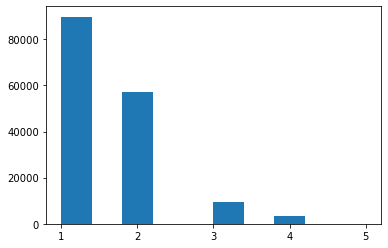

In [19]:
data["level"].hist(grid=False)

# 三、特征数据处理
## 3.1 构造新特征，根据建造年份构造建筑物年龄

In [20]:
import datetime
from datetime import datetime

dt = data["Date"]

# dt = datetime.strptime(dt, '%Y-%m-%d %H:%M:%S')
dt = dt.apply(lambda x:datetime.strptime(x, '%Y/%m/%d'))

data["year_now"] = dt.map(lambda x: x.year)
data['age_of_building'] = data['year_now'] - data['year of construction']
data.drop(columns=['year_now', 'Date', 'YYYYMM', 'USPD', 'type'], inplace=True)
data.head()

,M1,M2,delta_M,T1,T2,delta_T,Q,registrated,scheme,area,floors,walls material,year of construction,area of building,temp,Q_boxcox_lambda_opt,level,age_of_building
0,102.51,92.05,10.46,81.99,53.36,28.63,2.94,Heating + Hot water,opened,2707.4,5,panel,1983,4401.0,-17.782121,1.106611,1,33
1,124.86,125.29,-0.43,82.58,50.24,32.34,4.05,Heating + Hot water,closed,3358.4,5,brick,1974,3610.4,-17.782121,1.446404,2,42
2,127.31,128.51,-1.20,83.26,51.72,31.55,4.02,Heating + Hot water,closed,3153.5,5,brick,1975,3150.2,-17.782121,1.438458,2,41
3,86.36,81.61,4.75,92.55,54.82,37.73,3.26,Heating + Hot water,opened,2646.5,5,panel,1982,2932.7,-17.782121,1.215648,2,34
4,170.81,168.74,2.07,83.29,59.70,23.59,4.04,Heating + Hot water,closed,3187.5,5,brick,1976,3456.2,-17.782121,1.443762,2,40


In [21]:
data.columns

Index(['M1', 'M2', 'delta_M', 'T1', 'T2', 'delta_T', 'Q', 'registrated',
       'scheme', 'area', 'floors', 'walls material', 'year of construction',
       'area of building', 'temp', 'Q_boxcox_lambda_opt', 'level',
       'age_of_building'],
      dtype='object')

In [22]:
data_corr = data[['Q', 'M1', 'M2', 'delta_M', 'T1', 'T2', 'delta_T',  'registrated',
       'scheme', 'area', 'floors', 'walls material', 'year of construction',
       'area of building', 'temp', 'age_of_building']]
data_corr

,Q,M1,M2,delta_M,T1,T2,delta_T,registrated,scheme,area,floors,walls material,year of construction,area of building,temp,age_of_building
0,2.94,102.51,92.05,10.46,81.99,53.36,28.63,Heating + Hot water,opened,2707.4,5,panel,1983,4401.00,-17.782121,33
1,4.05,124.86,125.29,-0.43,82.58,50.24,32.34,Heating + Hot water,closed,3358.4,5,brick,1974,3610.40,-17.782121,42
2,4.02,127.31,128.51,-1.20,83.26,51.72,31.55,Heating + Hot water,closed,3153.5,5,brick,1975,3150.20,-17.782121,41
3,3.26,86.36,81.61,4.75,92.55,54.82,37.73,Heating + Hot water,opened,2646.5,5,panel,1982,2932.70,-17.782121,34
4,4.04,170.81,168.74,2.07,83.29,59.70,23.59,Heating + Hot water,closed,3187.5,5,brick,1976,3456.20,-17.782121,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164787,2.51,102.46,86.99,15.47,77.50,52.95,24.55,Heating + Hot water,opened,1886.0,9,panel,1979,13548.30,-8.144842,37
164788,2.29,79.47,71.58,7.89,77.56,48.82,28.74,Heating + Hot water,opened,2139.1,5,panel,1964,4262.06,-8.144842,52
164789,7.86,274.49,272.79,1.69,77.89,49.34,28.55,Heating + Hot water,closed,6609.2,10,panel,1999,12626.10,-8.144842,17
164790,7.50,436.13,437.33,-1.20,66.52,49.35,17.17,Heating + Hot water,closed,6447.4,5,brick,1988,7249.70,-8.144842,28


In [23]:
import scipy.stats as stats
def corr(x):

    pearson = data['Q'].corr(x, method='pearson')
    spearman = data['Q'].corr(x, method='spearman')
    kendall = data['Q'].corr(x, method='kendall')
    print('Pearson: %.2f' % pearson)
    print('Spearman: %.2f' % spearman)
    print('Kendall: %.2f' % kendall)


corr = abs(data_corr.corr())
corr


,Q,M1,M2,delta_M,T1,T2,delta_T,area,floors,year of construction,area of building,temp,age_of_building
Q,1.000000,0.733665,0.726016,0.131624,0.367231,0.326718,0.270063,0.796868,0.187744,0.137312,0.053559,0.304896,0.137312
M1,0.733665,1.000000,0.996981,0.084341,0.107496,0.180629,0.278553,0.773711,0.190898,0.175189,0.047151,0.043835,0.175189
M2,0.726016,0.996981,1.000000,0.006718,0.109983,0.181016,0.282260,0.768225,0.195565,0.187780,0.049132,0.041409,0.187780
delta_M,0.131624,0.084341,0.006718,1.000000,0.027019,0.003271,0.034869,0.105691,0.051191,0.153594,0.023265,0.033137,0.153594
T1,0.367231,0.107496,0.109983,0.027019,1.000000,0.713564,0.862581,0.044567,0.011968,0.024556,0.041397,0.813326,0.024556
T2,0.326718,0.180629,0.181016,0.003271,0.713564,1.000000,0.261064,0.021702,0.001129,0.022024,0.036179,0.612931,0.022024
delta_T,0.270063,0.278553,0.282260,0.034869,0.862581,0.261064,1.000000,0.045734,0.015676,0.049740,0.083166,0.678039,0.049740
area,0.796868,0.773711,0.768225,0.105691,0.044567,0.021702,0.045734,1.000000,0.290891,0.234546,0.166806,0.079048,0.234546
floors,0.187744,0.190898,0.195565,0.051191,0.011968,0.001129,0.015676,0.290891,1.000000,0.624203,0.607449,0.023204,0.624203
year of construction,0.137312,0.175189,0.187780,0.153594,0.024556,0.022024,0.049740,0.234546,0.624203,1.000000,0.347711,0.008081,1.000000


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


<Figure size 432x288 with 0 Axes>

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


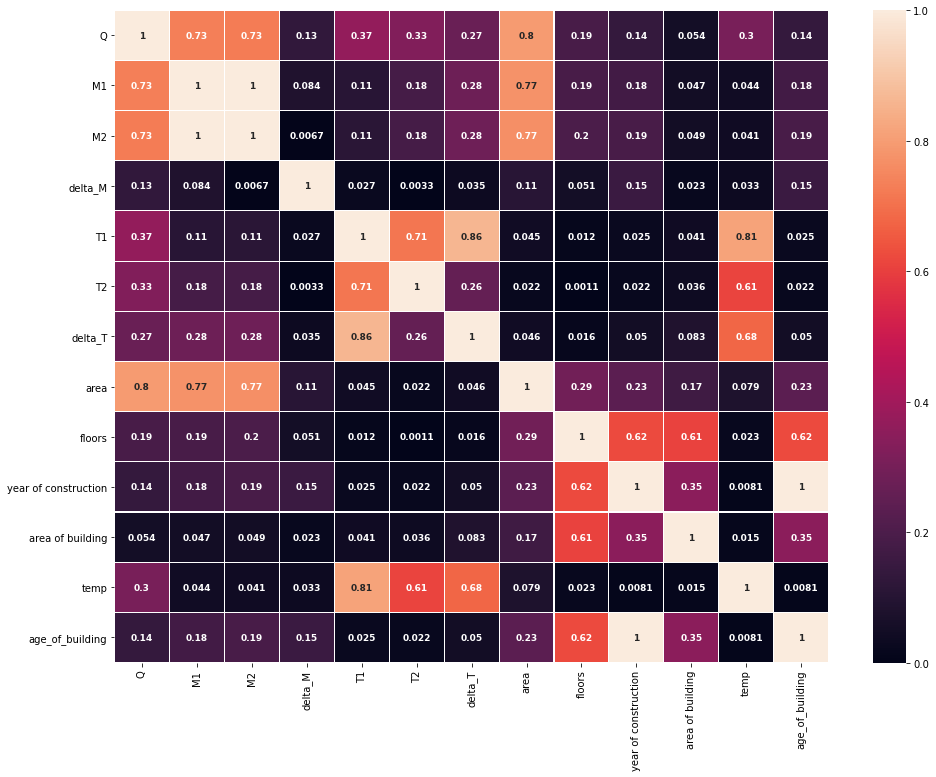

In [24]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
fig = plt.figure()
names=data_corr.columns
#fig.figsize:(40,40) #图片大小为20*20
# 以下代码用户显示中文
from pylab import *  
mpl.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus']=False

plt.figure(figsize=(16,12))
ax = sns.heatmap(corr, linewidths=0.05,vmax=1, vmin=0 ,annot=True,annot_kws={'size':9,'weight':'bold'})
#plt.xticks(np.arange(len(names))-2,names) #横坐标标注点
#plt.yticks(np.arange(len(names))-2,names) #纵坐标标注点
plt.show()


In [25]:
building_result = pd.DataFrame(data['area of building'].unique())
building_result.describe()

,0
count,930.000000
mean,5329.146839
std,4251.148498
min,361.800000
25%,3098.600000
50%,4280.825000
75%,5779.425000
max,32030.920000


In [26]:
building = pd.DataFrame(data['area'].unique())
building.describe()

,0
count,1086.000000
mean,3473.977330
std,2404.496879
min,330.700000
25%,2118.812500
50%,2906.150000
75%,3962.150000
max,18801.100000


In [27]:
data_building = data.groupby([data['area of building'], data['age_of_building'], data['floors'], data['walls material'], data['area']]).mean().reset_index()
data_building

,area of building,age_of_building,floors,walls material,area,M1,M2,delta_M,T1,T2,delta_T,Q,year of construction,temp,Q_boxcox_lambda_opt
0,361.80,64,2,wood,333.20,42.293333,41.126667,1.166667,87.990000,71.930000,16.060000,0.683333,1952,-19.284610,-0.377629
1,388.50,36,2,wood,382.60,21.923000,22.041000,-0.118000,92.429000,65.403000,27.026000,0.593000,1980,-19.420235,-0.517037
2,417.40,25,2,wood,330.70,20.554000,19.672000,0.882000,92.796000,61.132000,31.664000,0.588000,1991,-25.560413,-0.524652
3,513.20,3,3,brick,495.30,25.975870,26.318043,-0.342174,85.551739,57.490870,28.060870,0.709783,2013,-15.045296,-0.346312
4,544.30,60,2,wood,544.30,19.969355,20.376452,-0.407097,93.142258,57.789355,35.352903,0.700323,1956,-19.253928,-0.359537
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1092,32030.92,29,10,panel,2181.50,61.412846,56.802308,4.610538,79.211615,48.568846,30.642769,1.898000,1987,-7.592666,0.611042
1093,32030.92,29,10,panel,2346.52,61.550486,56.954583,4.595903,78.855208,47.604861,31.250347,1.934861,1987,-7.407624,0.628007
1094,32030.92,29,10,panel,2352.60,69.711131,63.924107,5.787024,78.254940,46.699226,31.555714,2.197202,1987,-6.957637,0.765573
1095,32030.92,29,10,panel,2367.50,64.307122,61.679209,2.627914,80.212590,48.519496,31.693094,2.059209,1987,-8.720614,0.698910


## 3.2 将类别数据OneHot Encoder处理

In [28]:
c = LabelEncoder().fit_transform(data['scheme'])
df_scheme = pd.DataFrame(c)
df_scheme.columns=['scheme']

c = LabelEncoder().fit_transform(data['floors'])
df_floors = pd.DataFrame(c)
df_floors.columns=['floors']

c = LabelEncoder().fit_transform(data['walls material'])
df_wallsMaterial = pd.DataFrame(c)
df_wallsMaterial.columns=['walls material']

c = LabelEncoder().fit_transform(data['registrated'])
df_registered = pd.DataFrame(c)
df_registered.columns=['registrated']

df_x=np.concatenate([df_scheme,df_wallsMaterial,df_registered,df_floors],axis=-1)
df_Label =pd.DataFrame(df_x)
df_Label

,0,1,2,3
0,1,3,1,3
1,0,1,1,3
2,0,1,1,3
3,1,3,1,3
4,0,1,1,3
...,...,...,...,...
160010,1,3,1,7
160011,1,3,1,3
160012,0,3,1,8
160013,0,1,1,3


In [29]:

data_Label = data.drop(columns=['scheme', 'registrated', 'floors', 'walls material'])
for item in df_Label.columns:
    data_Label[str(item)]=df_Label[item].values

data_Label.rename(columns={'0':'scheme', '1':'walls material', '2':'registered', '3':'floors'}, inplace=True)
data_Label

,M1,M2,delta_M,T1,T2,delta_T,Q,area,year of construction,area of building,temp,Q_boxcox_lambda_opt,level,age_of_building,scheme,walls material,registered,floors
0,102.51,92.05,10.46,81.99,53.36,28.63,2.94,2707.4,1983,4401.00,-17.782121,1.106611,1,33,1,3,1,3
1,124.86,125.29,-0.43,82.58,50.24,32.34,4.05,3358.4,1974,3610.40,-17.782121,1.446404,2,42,0,1,1,3
2,127.31,128.51,-1.20,83.26,51.72,31.55,4.02,3153.5,1975,3150.20,-17.782121,1.438458,2,41,0,1,1,3
3,86.36,81.61,4.75,92.55,54.82,37.73,3.26,2646.5,1982,2932.70,-17.782121,1.215648,2,34,1,3,1,3
4,170.81,168.74,2.07,83.29,59.70,23.59,4.04,3187.5,1976,3456.20,-17.782121,1.443762,2,40,0,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164787,102.46,86.99,15.47,77.50,52.95,24.55,2.51,1886.0,1979,13548.30,-8.144842,0.940769,1,37,1,3,1,7
164788,79.47,71.58,7.89,77.56,48.82,28.74,2.29,2139.1,1964,4262.06,-8.144842,0.845133,1,52,1,3,1,3
164789,274.49,272.79,1.69,77.89,49.34,28.55,7.86,6609.2,1999,12626.10,-8.144842,2.166516,3,17,0,3,1,8
164790,436.13,437.33,-1.20,66.52,49.35,17.17,7.50,6447.4,1988,7249.70,-8.144842,2.114848,3,28,0,1,1,3


In [30]:
data_building = data_Label.groupby([data_Label['area of building'], data_Label['age_of_building'], data_Label['floors'], data_Label['walls material'], data_Label['area']]).mean().reset_index()
data_building

,area of building,age_of_building,floors,walls material,area,M1,M2,delta_M,T1,T2,delta_T,Q,year of construction,temp,Q_boxcox_lambda_opt,scheme,registered
0,361.80,64,0,4,333.20,42.293333,41.126667,1.166667,87.990000,71.930000,16.060000,0.683333,1952.0,-19.284610,-0.377629,0.0,0.0
1,388.50,36,0,4,382.60,21.923000,22.041000,-0.118000,92.429000,65.403000,27.026000,0.593000,1980.0,-19.420235,-0.517037,0.0,0.0
2,417.40,25,0,4,330.70,20.554000,19.672000,0.882000,92.796000,61.132000,31.664000,0.588000,1991.0,-25.560413,-0.524652,1.0,1.0
3,513.20,3,1,1,495.30,25.975870,26.318043,-0.342174,85.551739,57.490870,28.060870,0.709783,2013.0,-15.045296,-0.346312,0.0,1.0
4,544.30,60,0,4,544.30,19.969355,20.376452,-0.407097,93.142258,57.789355,35.352903,0.700323,1956.0,-19.253928,-0.359537,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1092,32030.92,29,8,3,2181.50,61.412846,56.802308,4.610538,79.211615,48.568846,30.642769,1.898000,1987.0,-7.592666,0.611042,1.0,1.0
1093,32030.92,29,8,3,2346.52,61.550486,56.954583,4.595903,78.855208,47.604861,31.250347,1.934861,1987.0,-7.407624,0.628007,1.0,1.0
1094,32030.92,29,8,3,2352.60,69.711131,63.924107,5.787024,78.254940,46.699226,31.555714,2.197202,1987.0,-6.957637,0.765573,1.0,1.0
1095,32030.92,29,8,3,2367.50,64.307122,61.679209,2.627914,80.212590,48.519496,31.693094,2.059209,1987.0,-8.720614,0.698910,1.0,1.0


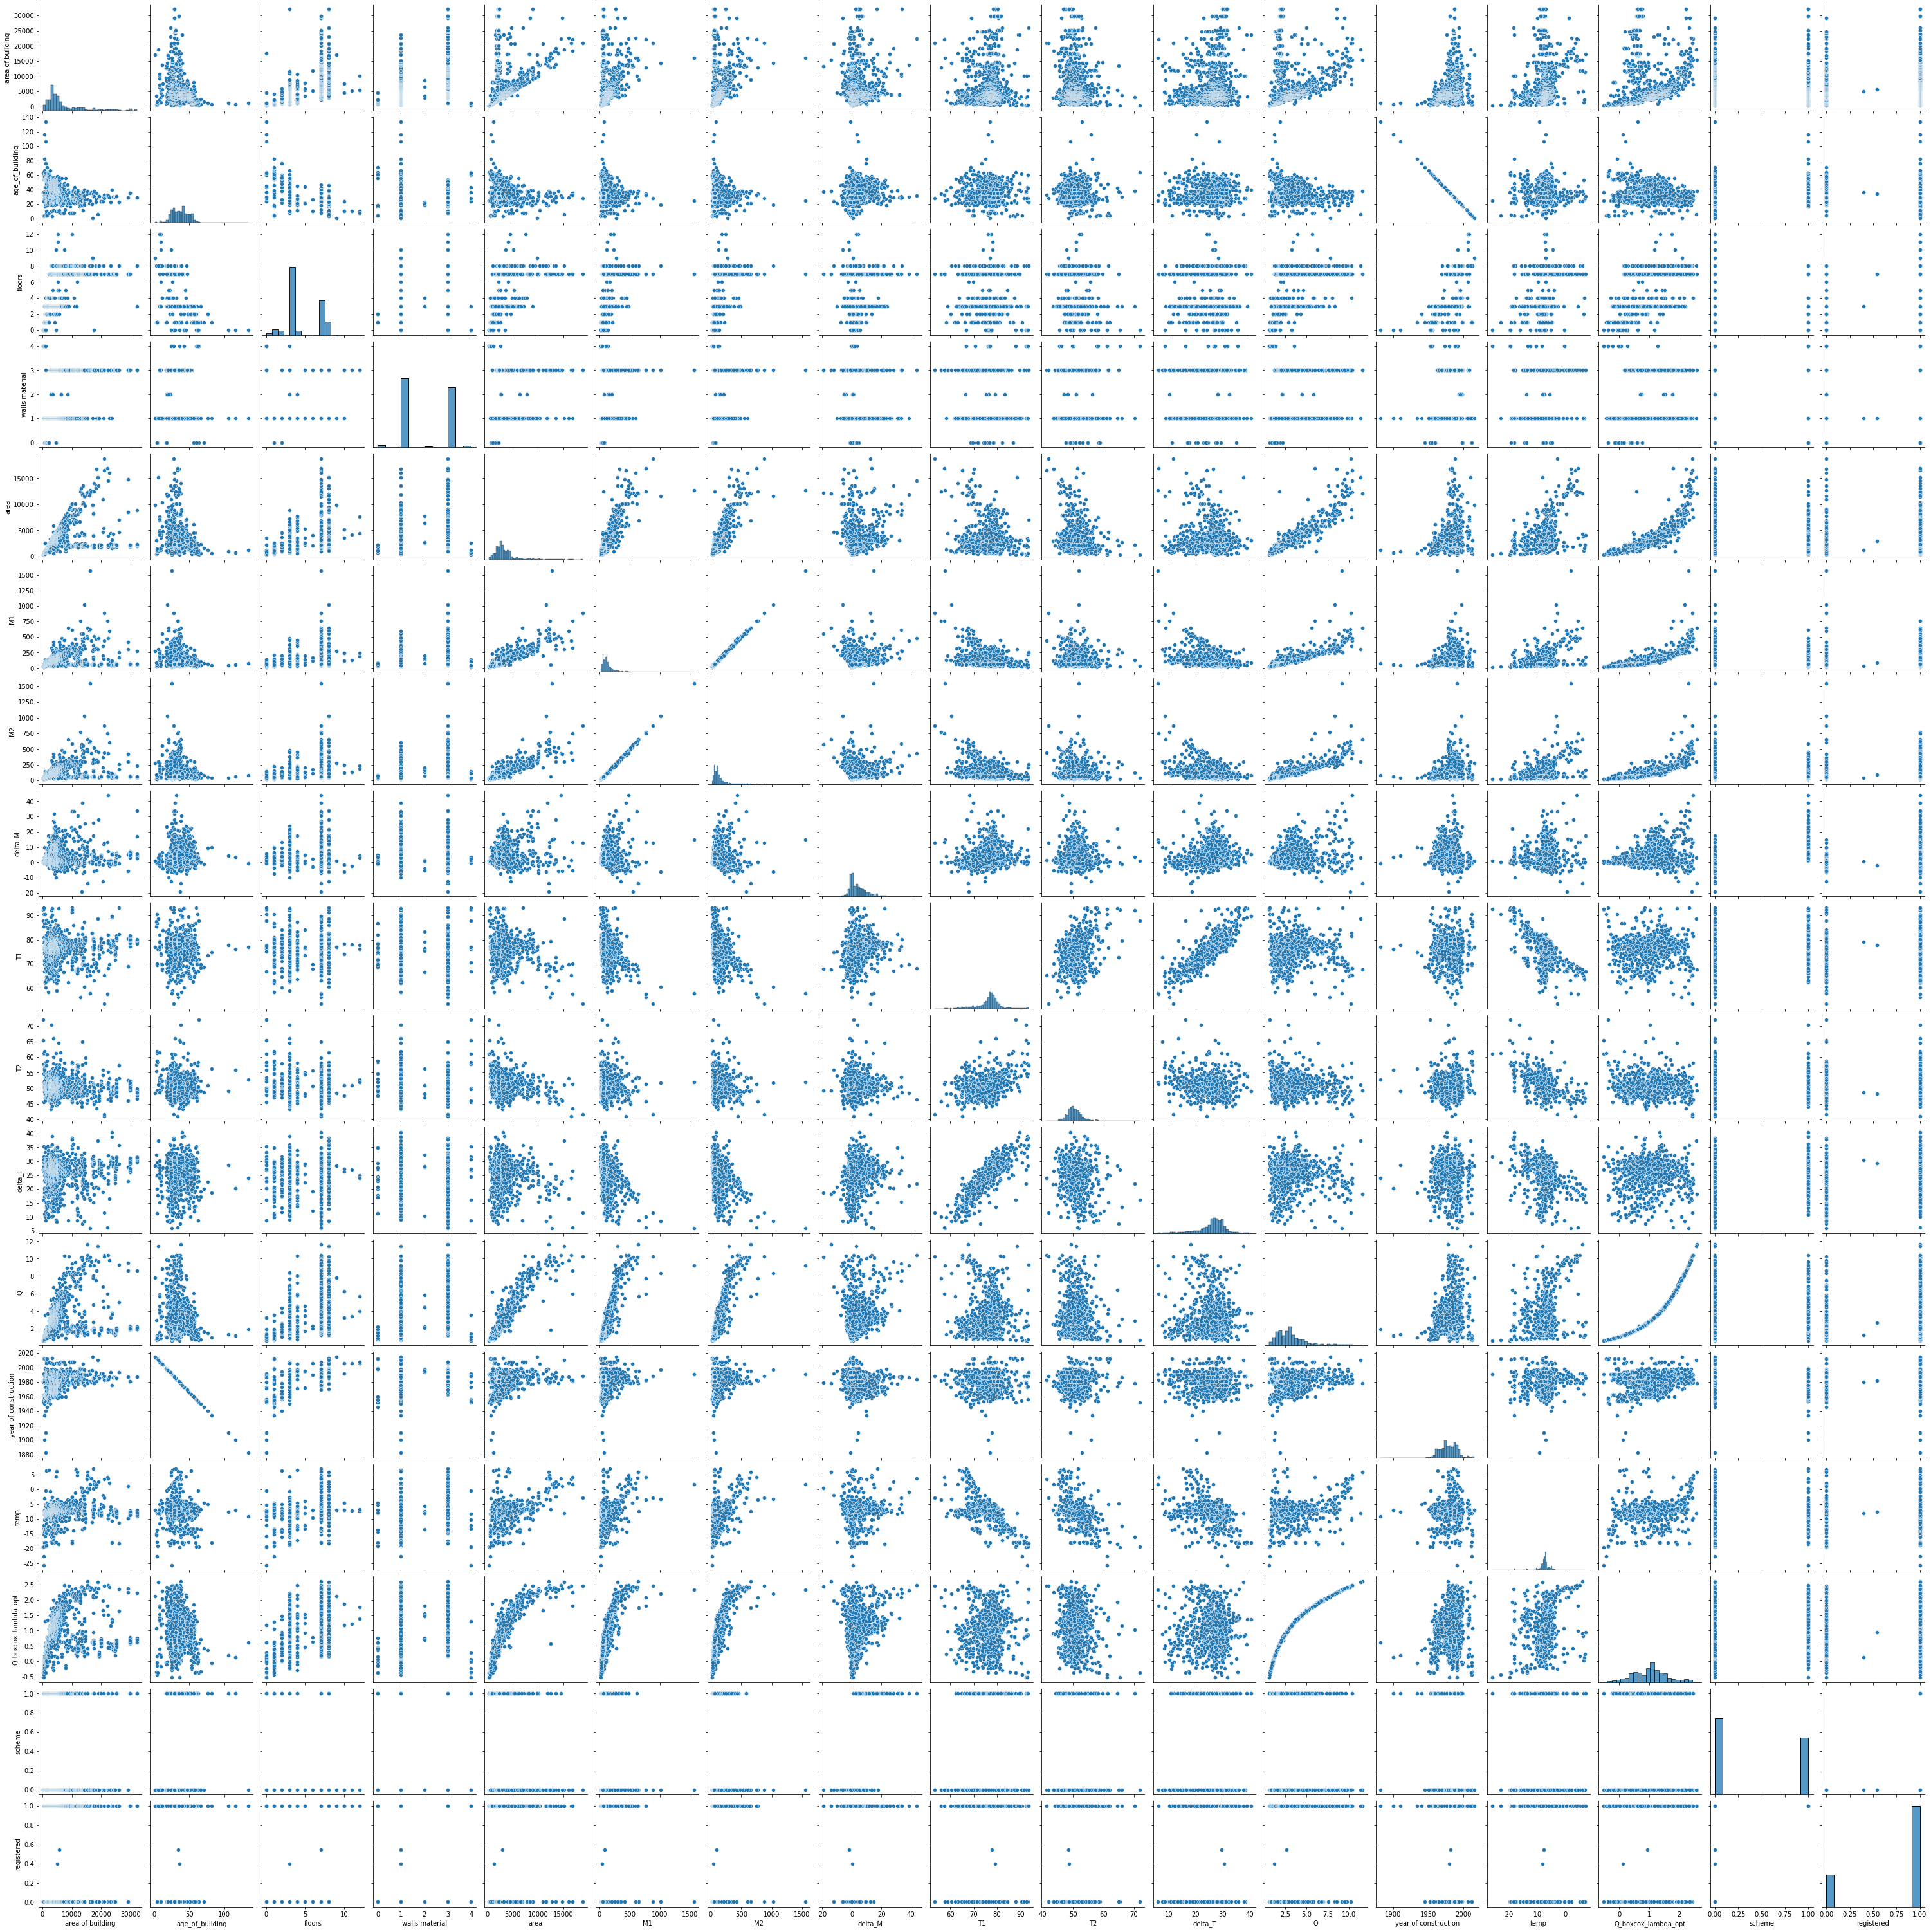

In [31]:
sns.pairplot(data=data_building)
plt.show()

## 3.3 处理目标值类别不平衡数

In [32]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
X = data_Label.drop(columns=['Q','level', 'year of construction', 'Q_boxcox_lambda_opt'])
y = data['level']
X.shape

(160015, 14)

In [33]:
from imblearn.over_sampling import RandomOverSampler  # 随机重复采样
from imblearn.over_sampling import SMOTE  # 选取少数类样本插值采样
from imblearn.combine import SMOTEENN, SMOTETomek

from collections import Counter
#在之前的SMOTE方法中, 当由边界的样本与其他样本进行过采样差值时, 很容易生成一些噪音数据. 因此, 在过采样之后需要对样本进行清洗. 这样, 第三节中涉及到的TomekLink 与 EditedNearestNeighbours方法就能实现上述的要求. 所以就有了两种结合过采样与下采样的方法: (i) SMOTETomek and (ii) SMOTEENN.
smo = SMOTETomek(random_state=42)
X_smo, y_smo = smo.fit_resample(X, y.astype('int'))

print(Counter(y_smo))
y_smo

Counter({5: 89756, 4: 89741, 3: 89702, 1: 89153, 2: 89114})


0         1
1         2
2         2
3         2
4         2
         ..
447461    5
447462    5
447463    5
447464    5
447465    5
Name: level, Length: 447466, dtype: int64

In [34]:
data_smo = pd.concat([X_smo, y_smo],axis=1)
data_smo.head()

,M1,M2,delta_M,T1,T2,delta_T,area,area of building,temp,age_of_building,scheme,walls material,registered,floors,level
0,102.51,92.05,10.46,81.99,53.36,28.63,2707.4,4401.0,-17.782121,33,1,3,1,3,1
1,124.86,125.29,-0.43,82.58,50.24,32.34,3358.4,3610.4,-17.782121,42,0,1,1,3,2
2,127.31,128.51,-1.20,83.26,51.72,31.55,3153.5,3150.2,-17.782121,41,0,1,1,3,2
3,86.36,81.61,4.75,92.55,54.82,37.73,2646.5,2932.7,-17.782121,34,1,3,1,3,2
4,170.81,168.74,2.07,83.29,59.70,23.59,3187.5,3456.2,-17.782121,40,0,1,1,3,2


## 3.5 进行数据采样

In [35]:
data_sample=data_smo.sample(frac=0.1,axis=0)
data_sample.describe()

,M1,M2,delta_M,T1,T2,delta_T,area,area of building,temp,age_of_building,scheme,walls material,registered,floors,level
count,44747.000000,44747.000000,44747.000000,44747.000000,44747.000000,44747.000000,44747.000000,44747.000000,44747.000000,44747.000000,44747.000000,44747.000000,44747.000000,44747.000000,44747.000000
mean,278.452400,273.350345,5.102111,79.983239,52.318387,27.664837,6655.469888,9877.451906,-9.979639,32.782980,0.304289,2.106867,0.826491,5.766018,3.019376
std,188.082171,188.014483,9.734334,10.989573,5.549506,7.780192,3774.031732,6265.369872,9.577600,10.561265,0.460111,0.984538,0.378691,2.157740,1.415210
min,17.570000,0.010000,-25.121715,41.270000,18.970000,3.150000,333.200000,361.800000,-32.582617,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,129.740000,124.650000,-0.570000,70.431655,48.259272,22.080000,3344.450000,4897.400000,-16.948776,26.000000,0.000000,1.000000,1.000000,3.000000,2.000000
50%,252.745738,246.299012,2.647530,79.768266,52.160000,27.820000,5940.290000,8651.800000,-11.106345,32.000000,0.000000,3.000000,1.000000,7.000000,3.000000
75%,380.286895,374.808663,8.796176,90.289697,56.390000,33.330135,9070.640000,13602.800000,-3.382806,38.000000,1.000000,3.000000,1.000000,7.000000,4.000000
max,1660.004044,1644.051451,312.670000,110.000000,87.510000,54.450000,18801.100000,32030.920000,16.963864,134.000000,1.000000,4.000000,1.000000,12.000000,5.000000


<AxesSubplot:>

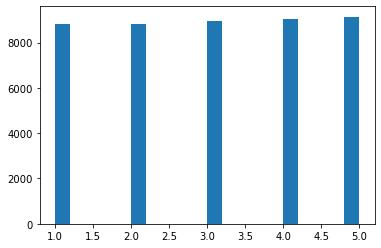

In [36]:
data_sample["level"].hist(bins=20, grid=False)

In [79]:
sample_X = data_sample.drop(columns=['level'])
sample_y = data_sample['level']
sample_X.describe()

,M1,M2,delta_M,T1,T2,delta_T,area,area of building,temp,age_of_building,scheme,walls material,registered,floors
count,44747.000000,44747.000000,44747.000000,44747.000000,44747.000000,44747.000000,44747.000000,44747.000000,44747.000000,44747.000000,44747.000000,44747.000000,44747.000000,44747.000000
mean,278.452400,273.350345,5.102111,79.983239,52.318387,27.664837,6655.469888,9877.451906,-9.979639,32.782980,0.304289,2.106867,0.826491,5.766018
std,188.082171,188.014483,9.734334,10.989573,5.549506,7.780192,3774.031732,6265.369872,9.577600,10.561265,0.460111,0.984538,0.378691,2.157740
min,17.570000,0.010000,-25.121715,41.270000,18.970000,3.150000,333.200000,361.800000,-32.582617,1.000000,0.000000,0.000000,0.000000,0.000000
25%,129.740000,124.650000,-0.570000,70.431655,48.259272,22.080000,3344.450000,4897.400000,-16.948776,26.000000,0.000000,1.000000,1.000000,3.000000
50%,252.745738,246.299012,2.647530,79.768266,52.160000,27.820000,5940.290000,8651.800000,-11.106345,32.000000,0.000000,3.000000,1.000000,7.000000
75%,380.286895,374.808663,8.796176,90.289697,56.390000,33.330135,9070.640000,13602.800000,-3.382806,38.000000,1.000000,3.000000,1.000000,7.000000
max,1660.004044,1644.051451,312.670000,110.000000,87.510000,54.450000,18801.100000,32030.920000,16.963864,134.000000,1.000000,4.000000,1.000000,12.000000


In [38]:
from sklearn.ensemble import RandomForestClassifier

X = sample_X.to_numpy()
y = sample_y.to_numpy()
best_accuracy, index_of_best_features = PSOptimizer((X, y), RandomForestClassifier, epochs = 10, threshold=0.6, verbose=1, max_depth=5)

Initial Accuracy: 0.805.
----------------------------------
*  Epoch:  1 | Accuracy: 0.839.
----------------------------------
*  Epoch:  2 | Accuracy: 0.845.
----------------------------------
*  Epoch:  3 | Accuracy: 0.845.
----------------------------------
*  Epoch:  4 | Accuracy: 0.845.
----------------------------------
*  Epoch:  5 | Accuracy: 0.849.
----------------------------------
*  Epoch:  6 | Accuracy: 0.852.
----------------------------------
*  Epoch:  7 | Accuracy: 0.852.
----------------------------------
*  Epoch:  8 | Accuracy: 0.853.
----------------------------------
*  Epoch:  9 | Accuracy: 0.854.
----------------------------------
*  Epoch: 10 | Accuracy: 0.855.
----------------------------------


In [39]:
index_of_best_features

array([ 0,  1,  3,  5,  6,  8, 10, 11, 12])

In [120]:
PSOptimizer_Feature = sample_X.iloc[:,index_of_best_features]
PSOptimizer_Feature

,M1,M2,T1,delta_T,area,temp,scheme,walls material,registered
442001,397.103646,396.611418,90.586983,30.322807,7981.400000,-16.134913,0,3,1
439999,591.992866,591.881749,72.228930,20.333755,11660.600000,-4.459896,0,3,1
105702,56.480000,54.970000,59.140000,15.960000,1873.600000,0.753091,0,3,0
195653,147.353263,136.594183,93.732261,42.355057,4671.000000,-16.013913,1,1,1
112126,199.840000,201.320000,58.290000,5.540000,1727.740000,-3.572274,0,3,0
...,...,...,...,...,...,...,...,...,...
403128,405.289608,400.758487,86.717529,29.699245,7858.689417,-10.444430,0,3,1
192124,226.277627,223.547779,92.351592,28.607339,4845.800000,-12.662623,0,1,1
298534,334.978722,337.143747,78.515529,31.843210,10067.000000,-10.951030,0,3,1
160454,73.899945,71.721833,100.150246,43.576544,1828.300000,-25.030443,1,3,1


## 降维

In [97]:
som_data = PSOptimizer_Feature.values
som_data.shape

(44747, 9)

In [112]:
#pca 降维
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
pca.fit(som_data)
pca_data = pca.transform(som_data)
predictions = pca_data


In [90]:
som = SOM(m=8, n=1, dim=9)
predictions = som.fit_transform(som_data)
predictions

array([[ 5731.89411228,  3620.38649632,  1578.8932723 , ...,
         3262.90554864,  4699.97989926,  5681.48180007],
       [ 2048.70784411,   103.38556745,  2120.35896117, ...,
         6952.38513741,  8389.47090512,  9370.97740152],
       [11856.3931933 ,  9746.46012842,  7700.9468178 , ...,
         2864.1191293 ,  1427.07150634,   446.22328731],
       ...,
       [ 3655.21056885,  1555.11001455,   511.97087542, ...,
         5340.5643281 ,  6776.8512528 ,  7758.43651593],
       [11900.26886239,  9790.06572067,  7744.71015576, ...,
         2907.60142096,  1470.77387163,   490.15065838],
       [13188.92469924, 11078.52615251,  9033.43433617, ...,
         4196.12726073,  2759.21693508,  1777.55639192]])

In [113]:
predictions.shape

(44747, 4)

In [114]:
som_data = pd.DataFrame(predictions)
som_data.head()
X_sample = som_data
X_sample

,0,1,2,3
0,1333.570485,94.208383,-14.549960,-3.534144
1,5022.563774,158.274028,5.793614,-3.326481
2,-4791.848876,-34.984452,29.229068,-1.416611
3,-1992.092741,-75.341207,-16.757461,3.707744
4,-4925.673661,178.099459,27.688406,-3.162500
...,...,...,...,...
44742,1211.569287,110.038495,-8.623049,-0.240968
44743,-1810.825895,32.004864,-10.025677,-1.504897
44744,3410.768879,-111.493106,-0.950158,-5.979949
44745,-4835.715560,-9.455283,-26.369792,-2.400169


In [115]:
#scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_sample)
X_sample = scaler.transform(X_sample)
X_sample = pd.DataFrame(X_sample)

In [116]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(sample_X)
X_sample = scaler.transform(sample_X)
X_sample = pd.DataFrame(sample_X)

# 四、模型构造

In [117]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from mlxtend.classifier import StackingCVClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

from xgboost import XGBClassifier
import lightgbm as lgb

RANDOM_SEED = 42

# 四、构造stacking模型
采用MLPClassifier，RandomForestClassifier，XGBClassifier构造集成模型

In [119]:
#clf1 = GradientBoostingClassifier(n_estimators=100, random_state=RANDOM_SEED)
#clf2 = RandomForestClassifier(random_state=RANDOM_SEED)
#clf3 = XGBClassifier(learning_rate=1,n_estimators=500, max_depth=8, min_child_weight = 1, gamma=0., subsample=0.8, objective='binary:logistic', eval_metric='mlogloss', random_state=RANDOM_SEED)
clf1 = lgb.LGBMClassifier(random_state=RANDOM_SEED)
clf2 = XGBClassifier(random_state=RANDOM_SEED)
clf3 = RandomForestClassifier(random_state=RANDOM_SEED)
lr = LogisticRegression()

sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3],  # 第一层分类器
                            meta_classifier=lr,   # 第二层分类器
                            random_state=RANDOM_SEED)

print('3-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3, sclf], ['LGBMClassifier', 'XGBClassifier', 'RandomForestClassifier','StackingClassifier']):
    scores = cross_val_score(clf, X_sample, sample_y, cv=5, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

3-fold cross validation:

Accuracy: 0.99 (+/- 0.00) [LGBMClassifier]
Accuracy: 0.93 (+/- 0.00) [XGBClassifier]
Accuracy: 0.99 (+/- 0.00) [RandomForestClassifier]
Accuracy: 0.99 (+/- 0.00) [StackingClassifier]


In [84]:
clf1.get_params().keys()

dict_keys(['boosting_type', 'class_weight', 'colsample_bytree', 'importance_type', 'learning_rate', 'max_depth', 'min_child_samples', 'min_child_weight', 'min_split_gain', 'n_estimators', 'n_jobs', 'num_leaves', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'silent', 'subsample', 'subsample_for_bin', 'subsample_freq'])

In [85]:
clf2.get_params().keys()

dict_keys(['base_score', 'booster', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'gamma', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'n_estimators', 'n_jobs', 'nthread', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'seed', 'silent', 'subsample', 'verbosity'])

In [86]:
clf3.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [87]:
sclf.get_params().keys()

dict_keys(['classifiers', 'cv', 'drop_proba_col', 'meta_classifier__C', 'meta_classifier__class_weight', 'meta_classifier__dual', 'meta_classifier__fit_intercept', 'meta_classifier__intercept_scaling', 'meta_classifier__l1_ratio', 'meta_classifier__max_iter', 'meta_classifier__multi_class', 'meta_classifier__n_jobs', 'meta_classifier__penalty', 'meta_classifier__random_state', 'meta_classifier__solver', 'meta_classifier__tol', 'meta_classifier__verbose', 'meta_classifier__warm_start', 'meta_classifier', 'n_jobs', 'pre_dispatch', 'random_state', 'shuffle', 'store_train_meta_features', 'stratify', 'use_clones', 'use_features_in_secondary', 'use_probas', 'verbose', 'lgbmclassifier', 'xgbclassifier', 'randomforestclassifier', 'lgbmclassifier__boosting_type', 'lgbmclassifier__class_weight', 'lgbmclassifier__colsample_bytree', 'lgbmclassifier__importance_type', 'lgbmclassifier__learning_rate', 'lgbmclassifier__max_depth', 'lgbmclassifier__min_child_samples', 'lgbmclassifier__min_child_weight

## 4.1 堆叠5折CV分类与网格搜索(结合网格搜索调参优化)

In [78]:

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from mlxtend.classifier import StackingCVClassifier

# Initializing models

#clf1 = MLPClassifier(alpha=1, max_iter=1000, random_state=RANDOM_SEED)
#clf2 = RandomForestClassifier(random_state=RANDOM_SEED)
#clf3 = XGBClassifier(objective='binary:logistic', eval_metric='mlogloss', random_state=RANDOM_SEED)
lr = LogisticRegression()

sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3], 
                            meta_classifier=lr,
                            verbose=1,
                            n_jobs=8,
                            random_state=RANDOM_SEED)

'''
'mlpclassifier__hidden_layer_sizes': [(10,30,10),(20,)],
    'mlpclassifier__activation': ['tanh', 'relu'],
    'mlpclassifier__solver': ['sgd', 'adam'],
    'mlpclassifier__learning_rate': ['constant','adaptive'],
'''

params = {
    'lgbmclassifier__learning_rate': [0.1, 1, 10],
    'lgbmclassifier__max_depth': range(1, 9, 2),
    'xgbclassifier__max_depth':range(7, 11, 2),
    'xgbclassifier__n_estimators':range(100, 900, 200), 
    'xgbclassifier__learning_rate':[0.1, 1.0, 10],
    'randomforestclassifier__max_depth':range(7, 11, 2),
    'randomforestclassifier__n_estimators':range(100, 900, 200)
    }
'''
'meta_classifier__C': [0.1, 1, 10.0],
    'max_depth':range(2, 7),
    'xgbclassifier__n_estimators':range(100, 1100, 200), 
    'xgbclassifier__learning_rate':[0.05, 0.1, 0.25, 0.5, 1.0],
'''

grid = GridSearchCV(estimator=sclf, 
                    param_grid=params, 
                    cv=5,
                    refit=True)
grid.fit(X_sample, sample_y)

cv_keys = ('mean_test_score', 'std_test_score', 'params')

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_[cv_keys[0]][r],
             grid.cv_results_[cv_keys[1]][r] / 2.0,
             grid.cv_results_[cv_keys[2]][r]))

print('Best parameters: %s' % grid.best_params_)
print('Accuracy: %.2f' % grid.best_score_)

Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   32.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   32.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   32.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   32.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   32.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   32.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   32.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   32.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   33.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   33.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   55.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   55.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   55.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   55.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   55.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   55.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   57.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   57.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   56.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   56.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.3min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.4min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.3min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.3min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.3min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.5s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   41.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   41.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   40.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   40.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   40.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   40.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   40.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   40.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   41.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   41.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.7min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.7min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.7min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.7min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.7min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   31.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   31.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   31.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   31.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   31.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   31.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   31.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   31.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   31.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   31.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   53.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   53.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   52.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   52.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   52.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   52.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   53.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   53.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   53.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   53.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.3min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.3min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.3min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.3min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.3min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   40.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   40.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   39.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   39.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   41.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   41.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   40.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   40.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   39.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   39.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.1min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.1min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.1min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.1min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.1min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.6min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.6min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.5s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.6min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.6min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.6min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.5s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    5.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    5.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    5.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    5.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    5.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    5.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    5.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    5.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    5.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    5.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   32.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   32.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   32.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   32.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   33.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   33.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   32.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   32.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   32.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   32.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.5s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   55.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   55.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   56.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   56.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.5s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   55.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   55.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   54.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   54.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   55.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   55.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.3min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.3min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.3min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.3min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.3min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.5s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   41.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   41.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   40.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   40.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   43.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   43.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.5s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   41.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   41.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   41.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   41.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.7min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.7min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.7min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.6min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.7min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   31.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   31.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   31.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   31.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   31.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   31.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   31.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   31.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   34.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   34.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   54.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   54.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   53.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   53.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   53.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   53.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   54.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   54.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   53.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   53.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.3min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.3min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.3min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.3min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.3min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   39.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   39.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.5s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   39.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   39.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   39.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   39.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   39.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   39.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   39.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   39.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.1min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.1min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.1min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.5s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.1min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.6min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.7min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.7min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.5s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.6min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.7min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.5s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.5s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.5s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.5s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.5s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.5s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.5s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.5s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.5s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.5s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.5s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   33.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   33.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.5s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   33.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   33.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   35.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   35.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   33.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   33.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   33.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   33.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   58.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   58.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   57.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   57.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   57.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   57.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   58.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   58.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   58.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   58.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.4min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.4min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.4min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.4min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.4min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   42.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   42.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   43.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   43.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   42.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   42.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   42.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   42.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   42.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   42.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.7min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.7min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.7min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.7min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.8min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   32.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   32.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   33.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   33.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   33.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   33.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   33.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   33.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   32.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   32.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   55.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   55.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   56.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   56.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   56.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   56.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   55.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   55.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   56.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   56.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.3min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.3min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.3min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.3min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.3min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   40.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   40.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   40.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   40.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.5s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   43.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   43.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   41.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   41.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   41.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   41.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.1min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.1min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.6min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.7min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.7min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.7min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.7min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.5s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.5s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.5s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.5s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   16.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   16.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   34.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   34.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   34.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   34.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   34.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   34.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   33.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   33.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   33.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   33.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   59.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   59.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   58.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   58.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   16.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   16.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   57.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   57.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   57.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   57.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   58.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   58.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   16.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   16.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.4min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.4min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   16.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   16.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.4min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.4min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.4min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   16.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   16.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   42.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   42.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   43.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   43.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   42.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   42.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   42.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   42.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   42.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   42.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   16.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   16.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   16.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   16.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   16.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   16.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.7min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   16.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   16.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.7min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.7min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   16.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   16.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.7min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   16.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   16.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.7min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   32.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   32.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   34.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   34.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   33.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   33.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   32.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   32.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   16.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   16.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   33.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   33.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   58.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   58.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   56.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   56.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   55.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   55.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   59.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   59.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   57.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   57.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.3min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.3min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.4min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.4min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.3min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   40.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   40.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   41.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   41.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   40.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   40.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   41.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   41.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   16.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   16.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   40.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   40.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   16.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   16.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   16.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   16.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.6min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   16.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   16.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.6min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.6min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.6min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.6min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   16.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   16.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   16.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   16.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.5s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   33.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   33.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   33.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   33.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   34.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   34.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   33.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   33.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   34.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   34.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   57.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   57.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   58.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   58.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   57.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   57.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   57.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   57.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   58.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   58.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.4min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.4min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.4min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    4.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    4.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.4min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.4min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   15.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.5s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   41.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   41.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   42.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   42.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   43.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   43.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   42.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   42.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   42.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   42.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.5s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    4.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.7min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.8min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.7min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.8min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.8min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    4.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.5s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   34.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   34.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   33.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   33.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   33.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   33.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   34.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   34.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   33.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   33.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   55.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   55.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.5s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   56.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   56.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   55.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   55.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   56.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   56.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   56.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   56.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.3min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.3min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.3min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.3min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.3min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   42.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   42.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   41.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   41.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.5s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   40.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   40.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   40.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   40.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   40.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   40.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    4.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  1.7min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.6s finished


KeyboardInterrupt: 

In [ ]:
sclf.get_params().keys()

dict_keys(['classifiers', 'cv', 'drop_proba_col', 'meta_classifier__C', 'meta_classifier__class_weight', 'meta_classifier__dual', 'meta_classifier__fit_intercept', 'meta_classifier__intercept_scaling', 'meta_classifier__l1_ratio', 'meta_classifier__max_iter', 'meta_classifier__multi_class', 'meta_classifier__n_jobs', 'meta_classifier__penalty', 'meta_classifier__random_state', 'meta_classifier__solver', 'meta_classifier__tol', 'meta_classifier__verbose', 'meta_classifier__warm_start', 'meta_classifier', 'n_jobs', 'pre_dispatch', 'random_state', 'shuffle', 'store_train_meta_features', 'stratify', 'use_clones', 'use_features_in_secondary', 'use_probas', 'verbose', 'mlpclassifier', 'randomforestclassifier', 'xgbclassifier', 'mlpclassifier__activation', 'mlpclassifier__alpha', 'mlpclassifier__batch_size', 'mlpclassifier__beta_1', 'mlpclassifier__beta_2', 'mlpclassifier__early_stopping', 'mlpclassifier__epsilon', 'mlpclassifier__hidden_layer_sizes', 'mlpclassifier__learning_rate', 'mlpclass

In [ ]:
clf1.get_params().keys()

dict_keys(['activation', 'alpha', 'batch_size', 'beta_1', 'beta_2', 'early_stopping', 'epsilon', 'hidden_layer_sizes', 'learning_rate', 'learning_rate_init', 'max_fun', 'max_iter', 'momentum', 'n_iter_no_change', 'nesterovs_momentum', 'power_t', 'random_state', 'shuffle', 'solver', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

In [ ]:
clf3.get_params().keys()

dict_keys(['objective', 'use_label_encoder', 'base_score', 'booster', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'gamma', 'gpu_id', 'importance_type', 'interaction_constraints', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'monotone_constraints', 'n_estimators', 'n_jobs', 'num_parallel_tree', 'random_state', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'subsample', 'tree_method', 'validate_parameters', 'verbosity', 'eval_metric'])

In [ ]:
from mlxtend.classifier import StackingCVClassifier
from mlxtend.feature_selection import ColumnSelector
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

X_train_feature, X_test_feature, y_train_feature, y_test_feature = train_test_split( X_sample, sample_y, test_size=0.33, random_state=RANDOM_SEED)

pipe1 = make_pipeline(ColumnSelector(cols=(0, 1, 2)),  # 选择第0,1,2列
                      MLPClassifier(alpha=1, max_iter=1000, random_state=RANDOM_SEED))
pipe2 = make_pipeline(ColumnSelector(cols=(3, 4, 5)),  # 选择第3,4,5列
                      XGBClassifier(eval_metric ='mlogloss', random_state=RANDOM_SEED ))
pipe3 = make_pipeline(ColumnSelector(cols=(6, 7)),  # 选择第6,7列
                      RandomForestClassifier(random_state=RANDOM_SEED))

sclf = StackingCVClassifier(classifiers=[pipe1, pipe2, pipe3], 
                            meta_classifier=LogisticRegression(),
                            random_state=42)

sclf.fit(X_train_feature, y_train_feature)
predict = sclf.predict(X_test_feature)

Accuracy = accuracy_score(predict, y_test_feature) 
print(Accuracy)


0.9771047413016045


In [ ]:
data_2015 = pd.read_csv('2015.csv')
import autoBinning
from autoBinning.utils.forwardSplit import *
# sby='woeiv'时考虑woe趋势，sby='iv'时不考虑woe趋势
t = forwardSplit(data_2015['Q, Gcal'], data_2015['Q, Gcal'])
t.fit(sby='iv',minv=0.1,init_split=6)
print(t.bins) 
t = forwardSplit(data_2015['Q, Gcal'], data_2015['Q, Gcal'])
t.fit(sby='iv',num_split=6,init_split=6)
print(t.bins) 
t.fit(sby='woeiv',num_split=6,init_split=6)
print(t.bins)

print("bin\twoe")
for i in range(len(t.bins)-1):
    v = t.value[(t.x < t.bins[i+1]) & (t.x >= t.bins[i])]
    woe = t._cal_woe(v)
    print((t.bins[i], t.bins[i+1]),woe)
from pandas import Series, DataFrame
bins=[0,5,10,15,20,25,30]
bin_data = pd.cut(data_2015['Q, Gcal'], bins)
print(pd.value_counts(bin_data))

def func(x):
    if ((x<5) & (x>0)):
        return "1"
    elif ((x>=5) & (x<10)):
        return "2"
    elif ((x>=10) & (x<15)):
        return "3"
    elif ((x>=15) & (x<20)):  
        return "4"
    elif ((x>=20) & (x<25)):  
        return "5"
    elif ((x>=25) & (x<30)):
        return "6"
    elif (x>=30):
        return "7"
    else:
        return 'N/A'
data_2015['level'] = data_2015['Q, Gcal'].apply(func)
data_2015.describe()

None
[1.000e-02 1.340e+00 1.930e+00 2.965e+01]
[1.000e-02 1.340e+00 1.930e+00 2.500e+00 3.220e+00 4.420e+00 2.965e+01]
bin	woe
(0.01, 1.34) 1.8103900165938955
(1.34, 1.93) 0
(1.93, 2.5) 0
(2.5, 3.22) 0
(3.22, 4.42) 0
(4.42, 29.65) 0
(0, 5]      150926
(5, 10]      17183
(10, 15]      3542
(15, 20]       811
(20, 25]        98
(25, 30]         7
Name: Q, Gcal, dtype: int64


,"М1, t","М2, t","ΔМ, t","Т1, °C","Т2, °C","ΔТ, °C","Q, Gcal",USPD,YYYYMM,type,area,floors,year of construction,area of building,"temp,˚C"
count,172567.000000,172567.000000,172567.000000,172567.000000,172567.000000,172567.000000,172567.000000,172567.000000,172567.000000,172567.000000,172567.000000,172567.000000,172567.000000,172567.000000,172567.000000
mean,144.345411,139.770653,4.574765,72.463755,49.795128,22.668633,3.100437,1107.804760,201519.620014,1650.626545,3455.761014,6.557285,1978.929019,7242.541120,-4.081034
std,120.503963,118.900383,15.371093,9.316013,5.645538,6.873120,2.402012,789.070162,37.159725,475.027188,2346.394561,2.342175,12.493900,6406.722269,8.881850
min,0.470000,0.010000,-26.400000,40.050000,18.300000,2.030000,0.010000,1.000000,201501.000000,1101.000000,121.800000,1.000000,1882.000000,121.800000,-30.545012
25%,73.595000,70.030000,-0.090000,65.590000,46.240000,18.130000,1.630000,456.000000,201502.000000,1105.000000,2124.800000,5.000000,1970.000000,3419.600000,-9.892362
50%,113.870000,108.220000,2.380000,71.250000,49.580000,22.320000,2.500000,979.000000,201504.000000,2005.000000,2884.900000,5.000000,1980.000000,4797.740000,-3.161290
75%,168.200000,163.450000,7.390000,78.400000,53.220000,26.950000,3.710000,1678.000000,201510.000000,2105.000000,3946.000000,9.000000,1988.000000,8619.500000,1.674844
max,5723.500000,1774.440000,5173.200000,106.300000,86.700000,56.310000,29.650000,3129.000000,201609.000000,2117.000000,16849.980000,17.000000,2015.000000,32030.920000,16.177975


<AxesSubplot:>

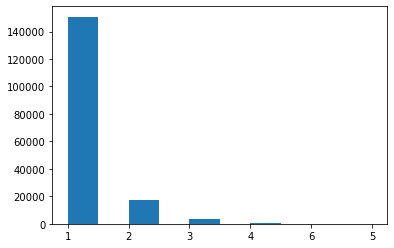

In [ ]:
data_2015["level"].hist(grid=False)

In [ ]:
import datetime
from datetime import datetime

dt = data_2015["Date"]

# dt = datetime.strptime(dt, '%Y-%m-%d %H:%M:%S')
dt = dt.apply(lambda x:datetime.strptime(x, '%Y/%m/%d'))

data_2015["year_now"] = dt.map(lambda x: x.year)
data_2015['age of building'] = data_2015['year_now'] - data_2015['year of construction']
data_2015.drop(columns=['year_now', 'Date', 'YYYYMM', 'USPD', 'type'], inplace=True)
data_2015.describe()

,"М1, t","М2, t","ΔМ, t","Т1, °C","Т2, °C","ΔТ, °C","Q, Gcal",area,floors,year of construction,area of building,"temp,˚C",age of building
count,172567.000000,172567.000000,172567.000000,172567.000000,172567.000000,172567.000000,172567.000000,172567.000000,172567.000000,172567.000000,172567.000000,172567.000000,172567.000000
mean,144.345411,139.770653,4.574765,72.463755,49.795128,22.668633,3.100437,3455.761014,6.557285,1978.929019,7242.541120,-4.081034,36.070981
std,120.503963,118.900383,15.371093,9.316013,5.645538,6.873120,2.402012,2346.394561,2.342175,12.493900,6406.722269,8.881850,12.493900
min,0.470000,0.010000,-26.400000,40.050000,18.300000,2.030000,0.010000,121.800000,1.000000,1882.000000,121.800000,-30.545012,0.000000
25%,73.595000,70.030000,-0.090000,65.590000,46.240000,18.130000,1.630000,2124.800000,5.000000,1970.000000,3419.600000,-9.892362,27.000000
50%,113.870000,108.220000,2.380000,71.250000,49.580000,22.320000,2.500000,2884.900000,5.000000,1980.000000,4797.740000,-3.161290,35.000000
75%,168.200000,163.450000,7.390000,78.400000,53.220000,26.950000,3.710000,3946.000000,9.000000,1988.000000,8619.500000,1.674844,45.000000
max,5723.500000,1774.440000,5173.200000,106.300000,86.700000,56.310000,29.650000,16849.980000,17.000000,2015.000000,32030.920000,16.177975,133.000000


In [ ]:
c = LabelEncoder().fit_transform(data_2015['scheme'])
df_scheme = pd.DataFrame(c)
df_scheme.columns=['scheme']

c = LabelEncoder().fit_transform(data_2015['floors'])
df_floors = pd.DataFrame(c)
df_floors.columns=['floors']

c = LabelEncoder().fit_transform(data_2015['walls material'])
df_wallsMaterial = pd.DataFrame(c)
df_wallsMaterial.columns=['walls material']

c = LabelEncoder().fit_transform(data_2015['registrated'])
df_registered = pd.DataFrame(c)
df_registered.columns=['registrated']

df_x=np.concatenate([df_scheme,df_wallsMaterial,df_registered,df_floors],axis=-1)
df_Label =pd.DataFrame(df_x)

data_Label = data_2015.drop(columns=['scheme', 'registrated', 'floors', 'walls material'])
for item in df_Label.columns:
    data_Label[str(item)]=df_Label[item].values

data_Label.rename(columns={'0':'scheme', '1':'walls material', '2':'registered', '3':'floors'}, inplace=True)
print (data_Label.describe())

               М1, t          М2, t          ΔМ, t         Т1, °C  \
count  172567.000000  172567.000000  172567.000000  172567.000000   
mean      144.345411     139.770653       4.574765      72.463755   
std       120.503963     118.900383      15.371093       9.316013   
min         0.470000       0.010000     -26.400000      40.050000   
25%        73.595000      70.030000      -0.090000      65.590000   
50%       113.870000     108.220000       2.380000      71.250000   
75%       168.200000     163.450000       7.390000      78.400000   
max      5723.500000    1774.440000    5173.200000     106.300000   

              Т2, °C         ΔТ, °C        Q, Gcal           area  \
count  172567.000000  172567.000000  172567.000000  172567.000000   
mean       49.795128      22.668633       3.100437    3455.761014   
std         5.645538       6.873120       2.402012    2346.394561   
min        18.300000       2.030000       0.010000     121.800000   
25%        46.240000      18.1300

In [ ]:
X_2015 = data_Label.drop(columns=['Q, Gcal','level', 'year of construction'])
y_2015 = data_2015['level']
X_2015

,"М1, t","М2, t","ΔМ, t","Т1, °C","Т2, °C","ΔТ, °C",area,area of building,"temp,˚C",age of building,scheme,walls material,registered,floors
0,120.51,120.83,-0.32,83.51,48.85,34.65,3358.40,3610.40,-4.959921,41,0,1,1,4
1,123.61,124.93,-1.32,85.14,51.34,33.80,3153.50,3150.20,-4.959921,40,0,1,1,4
2,129.96,129.04,0.93,85.63,51.78,33.85,3187.50,3456.20,-4.959921,39,0,1,1,4
3,102.04,84.42,17.61,85.83,53.30,32.52,2509.35,3382.25,-4.959921,48,1,1,1,4
4,169.23,172.24,-3.02,84.18,56.15,28.03,3574.70,5138.10,-4.959921,33,0,1,1,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172562,85.13,82.19,2.94,72.13,54.11,18.02,1421.60,1421.60,-5.065225,9,0,1,1,5
172563,90.35,90.29,0.06,75.81,49.66,26.15,2712.70,5679.10,-5.065225,29,0,1,1,4
172564,103.41,103.51,-0.10,75.93,50.86,25.07,2724.90,5647.80,-5.065225,29,0,1,1,4
172565,257.33,258.14,-0.81,75.81,45.48,30.33,9834.00,17149.70,-5.065225,0,0,1,1,10


from sklearn.metrics import accuracy_score  
pre_level_2015 = grid.predict(X_2015)
Accuracy = accuracy_score(y_2015, pre_level_2015)
print ('采用2015年的数据验证由2016年数据训练的模型：Accuracy: %.2f' % Accuracy)

In [ ]:
y_2015_arr = y_2015.values
y_2015_arr

In [ ]:
from sklearn import preprocessing


y_2015 = label_binarize(y_2015_arr, classes=['1', '2', '3', '4', '5', '6'])
n_classes = y_2015.shape[1]
y_2015

In [ ]:
n_classes

In [ ]:
# 5.ROC曲线 decision_function
### 像其他scikit-learn分类器一样，它StackingCVClassifier具有decision_function可用于绘制ROC曲线的方法。
### 请注意，decision_function期望并要求元分类器实现decision_function。
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingCVClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

RANDOM_SEED = 42

X_train, X_test, y_train, y_test = train_test_split(
    X_2015, y_2015, test_size=0.33, random_state=RANDOM_SEED)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(sclf)
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

n_class = y_2015.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_class):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# 对不同特征子集进行训练

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense,Dropout,LSTM,Bidirectional,Embedding
#from keras.layers import Embedding
from sklearn.metrics import r2_score
from keras.models import  Sequential
from sklearn.metrics import mean_squared_error,mean_absolute_error

X_train, X_test, y_train, y_test = train_test_split(
    PSOptimizer_Feature, y, test_size=0.33, random_state=RANDOM_SEED)
#搭建模型
LSTMClassifier=Sequential()
#model.add(Embedding(max_features,128,input_length=trainx.shape[0]))
#神经元个数50，可调
LSTMClassifier.add(Bidirectional(LSTM(100,input_shape=(PSOptimizer_Feature.shape[1],PSOptimizer_Feature.shape[2]))))
LSTMClassifier.add(Dropout(0.4))   #辍学率，可调
LSTMClassifier.add(Dense(1,activation='sigmoid'))   #sigmoid
LSTMClassifier.compile(optimizer='sgd', loss=tf.keras.losses.CategoricalCrossentropy())
#可调迭代次数，batch_size
LSTMClassifier.fit(PSOptimizer_Feature,y,batch_size=32,epochs = 10,verbose=2)
predict = LSTMClassifier.predict(testx)

Accuracy = accuracy_score(predict, y_test)
print(Accuracy)

LSTMClassifier

In [ ]:
X_sample.shape

In [ ]:
y.shape

In [ ]:

from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from mlxtend.classifier import StackingCVClassifier

# Initializing models

clf1 = MLPClassifier(alpha=1, max_iter=1000, random_state=RANDOM_SEED)
clf2 = RandomForestClassifier(random_state=RANDOM_SEED)
clf3 = XGBClassifier(learning_rate=0.1,n_estimators=100, max_depth=6, min_child_weight = 1, gamma=0., subsample=0.8, objective='binary:logistic', eval_metric='mlogloss', random_state=RANDOM_SEED)
lr = LogisticRegression()

sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3], 
                            meta_classifier=lr,
                            random_state=42)

params = {'hidden_layer_sizes': [(10,30,10),(20,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
    'meta_classifier__C': [0.1, 1, 10.0],
    'max_depth':range(2, 7), 
    'n_estimators':range(100, 1100, 200), 
    'learning_rate':[0.05, 0.1, 0.25, 0.5, 1.0]}

grid = GridSearchCV(estimator=sclf, 
                    param_grid=params, 
                    cv=5,
                    refit=True,
                    verbose=1,
                    n_jobs=4 )
grid.fit(X_sample, y)

cv_keys = ('mean_test_score', 'std_test_score', 'params')

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_[cv_keys[0]][r],
             grid.cv_results_[cv_keys[1]][r] / 2.0,
             grid.cv_results_[cv_keys[2]][r]))

print('Best parameters: %s' % grid.best_params_)
print('Accuracy: %.2f' % grid.best_score_)